### Topic: Predict the number of Confirmed cases in 20 days

In [1]:
# important packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# models
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
# data processing / metric
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, accuracy_score
plt.style.use('fivethirtyeight')

In [2]:
# read in & seperate Confirmed , Deaths , Recovers cases

world_confirmed_df = pd.read_csv('~/Desktop/csci/4622/covid-19/time_series_covid_19_confirmed.csv')
world_deaths_df = pd.read_csv('~/Desktop/csci/4622/covid-19/time_series_covid_19_deaths.csv')
world_recovered_df = pd.read_csv('~/Desktop/csci/4622/covid-19/time_series_covid_19_recovered.csv')


In [3]:
world_confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,996,1026,1092,1176,1279,1351,1463,1531,1703,1828
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,562,584,609,634,663,678,712,726,736,750
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,713,717,717,723,723,731,738,738,743,743
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,24,24,24,25,25,25,25,26,27,27


In [4]:
world_deaths_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,33,36,36,40,42,43,47,50,57,58
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,26,26,26,27,27,27,27,28,28,30
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,375,384,392,402,407,415,419,425,432,437
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,36,37,37,37,37,40,40,40,40,41
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [5]:
world_recovered_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,131,135,150,166,179,188,188,207,220,228
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,314,327,345,356,385,394,403,410,422,431
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1047,1099,1152,1204,1355,1408,1479,1508,1558,1651
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,235,248,282,309,333,344,344,344,385,398
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6


#### By showing heads of each dataframe, we can find that Provice/State contains all NaNs. Plus, our goal is to predict confirmed cases' growth. Hence, all column from [1:4] are not related to our project. We can drop them and take out dates-only columns.

In [6]:
# get the latest date information of covid-19
world_confirmed_df.keys()
# we can do another simple way which is take out all dates columns instead of dropping first 4 columns
# 4/28/20
# date starts at loc[4:-1] in df
# initial date = 1/22/20

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '4/19/20', '4/20/20', '4/21/20', '4/22/20', '4/23/20', '4/24/20',
       '4/25/20', '4/26/20', '4/27/20', '4/28/20'],
      dtype='object', length=102)

In [7]:
# get all dates
unclean_title = world_confirmed_df.keys()

dates_confirmed = world_confirmed_df.loc[:, unclean_title[4]:unclean_title[-1]]
dates_deaths = world_deaths_df.loc[:, unclean_title[4]:unclean_title[-1]]
dates_recovered = world_recovered_df.loc[:, unclean_title[4]:unclean_title[-1]]


In [8]:
# data checking:
'''
    Because we have already check the total dataframe's data previously, and we have drop out all
    unrelated columns. Therefore, at here, we are doing a recheck for all our required data.
'''
dates_confirmed.isnull().any().tolist()
# dates_deaths.isnull().any()
# dates_recovered.isnull().any()
# dates_confirmed

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [9]:
clean_dates = dates_confirmed.keys()

world_confirmed = []
world_deaths    = []
world_recovered = []

recover_rate    = []
death_rate      = []


In [10]:
for i in clean_dates:
    tot_c = np.sum(dates_confirmed[i])
    tot_d = np.sum(dates_deaths[i])
    tot_r = np.sum(dates_recovered[i])
    
    world_confirmed.append(tot_c)
    world_deaths.append(tot_d)
    world_recovered.append(tot_r)
    
    # calculate the rate for deaths and recovers
    recover_rate.append(float(tot_d / tot_c))
    death_rate.append(float(tot_r / tot_c))
    

In [11]:
# compute the daily increase around the world

def daily_increase(case):
    temp = []
    for i in range(len(case)):
        temp.append(case[0] if i == 0 else case[i]-case[i-1])
    return temp

daily_confirmed = daily_increase(world_confirmed)
daily_deaths = daily_increase(world_deaths)
daily_recovered = daily_increase(world_recovered)


In [12]:
# convert all list into 1-col np.array
dates_since_1_22 = np.array([i for i in range(len(clean_dates))]).reshape(-1, 1)
world_confirmed = np.array(world_confirmed).reshape(-1, 1)
world_deaths = np.array(world_deaths).reshape(-1, 1)
world_recovered = np.array(world_recovered).reshape(-1, 1)


In [13]:
# general information visulizations
dates = dates_since_1_22.reshape(1, -1)[0]

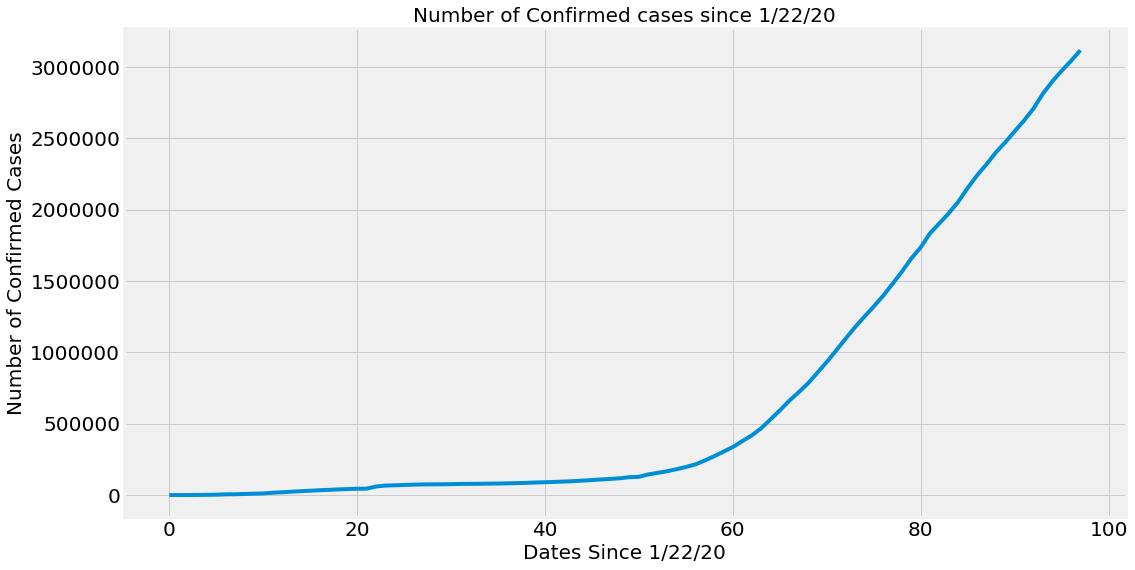

In [14]:
# world-wide confirmed cases curve
plt.figure(figsize=(16, 9))
plt.plot(dates, world_confirmed)
plt.title('Number of Confirmed cases since 1/22/20', size=20)
plt.xlabel('Dates Since 1/22/20', size=20)
plt.ylabel('Number of Confirmed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

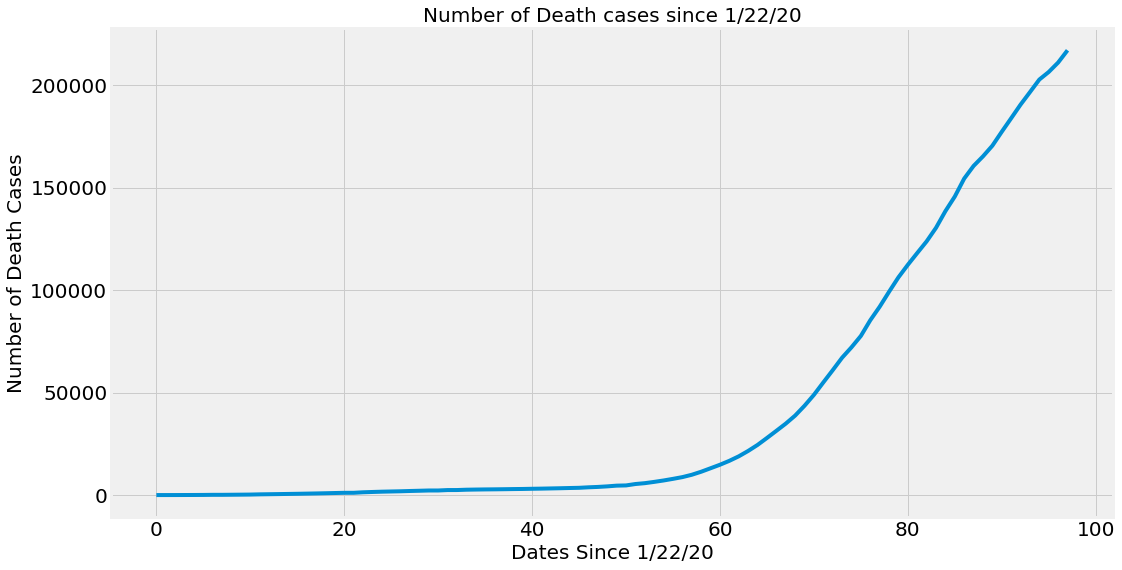

In [15]:
# world-wide deaths cases curve
plt.figure(figsize=(16, 9))
plt.plot(dates, world_deaths)
plt.title('Number of Death cases since 1/22/20', size=20)
plt.xlabel('Dates Since 1/22/20', size=20)
plt.ylabel('Number of Death Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

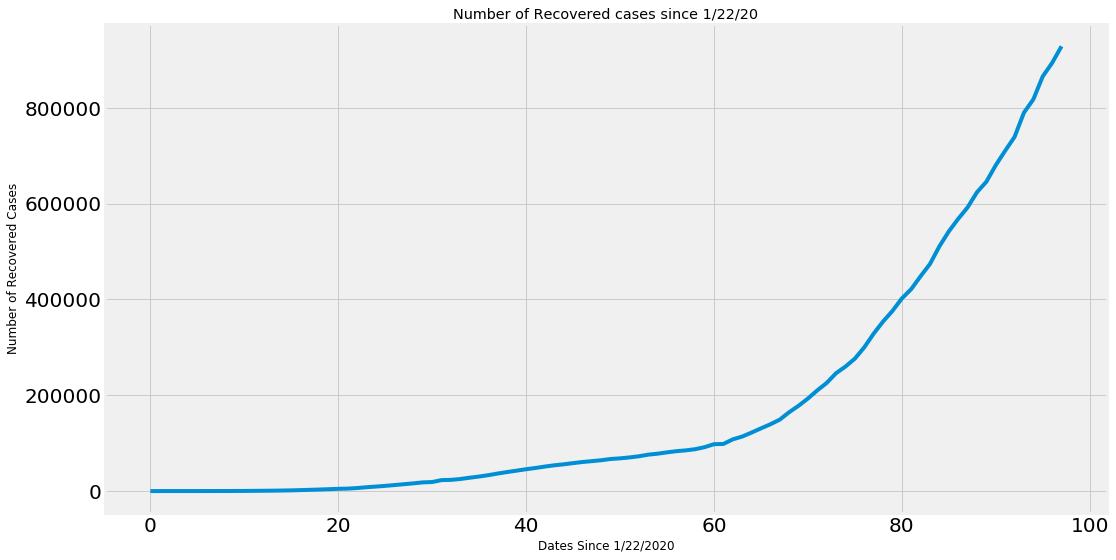

In [16]:
# world-wide recovered cases curve
plt.figure(figsize=(16, 9))
plt.plot(dates, world_recovered)
plt.title('Number of Recovered cases since 1/22/20')
plt.xlabel('Dates Since 1/22/2020')
plt.ylabel('Number of Recovered Cases')
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

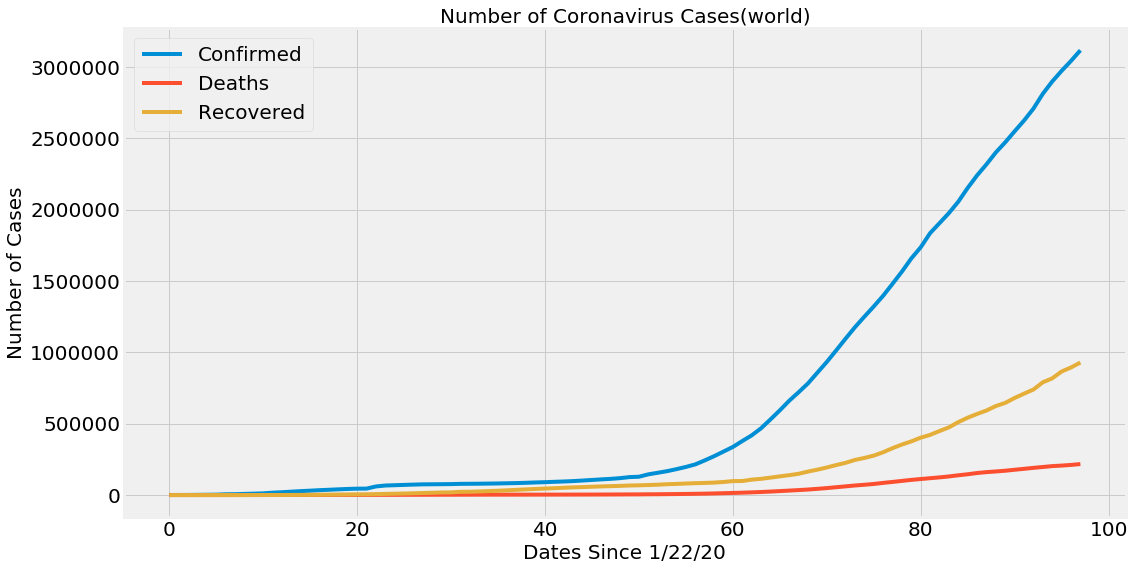

In [17]:
# Let's see the trend among these 3 types of case
plt.figure(figsize=(16, 9))
plt.plot(dates, world_confirmed)
plt.plot(dates, world_deaths)
plt.plot(dates, world_recovered)
plt.title('Number of Coronavirus Cases(world)', size=20)
plt.xlabel('Dates Since 1/22/20', size=20)
plt.ylabel('Number of Cases', size=20)
plt.legend(['Confirmed', 'Deaths', 'Recovered'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [18]:
# Start building up our models

future = 20  #  we are predicting 20 days in the future
pred_future = np.array([i for i in range(len(clean_dates) + future)]).reshape(-1, 1)

In [19]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(dates_since_1_22, \
                                                            world_confirmed,test_size=.3, \
                                                            shuffle=False)

In [20]:
# shape data for polynomial regression
poly = PolynomialFeatures(degree=3)
poly_X_train_c = poly.fit_transform(X_train_c)
poly_X_test_c = poly.fit_transform(X_test_c)
poly_pred_future = poly.fit_transform(pred_future)

In [21]:
# polynomial linear regression
linear_model = LinearRegression(normalize=True)
linear_model.fit(poly_X_train_c, y_train_c)
test_linear_pred = linear_model.predict(poly_X_test_c)

poly_pred = linear_model.predict(poly_pred_future)

# different metrics for evaluating our model's performance
print('Polynomial Regression MAE:', mean_absolute_error(test_linear_pred, y_test_c))
print('Polynomial Regression MSE:',mean_squared_error(test_linear_pred, y_test_c))

Polynomial Regression MAE: 208887.2224367045
Polynomial Regression MSE: 51711011682.710304


In [22]:
ss = StandardScaler()
x_train = ss.fit_transform(X_train_c)
x_test = ss.transform(X_test_c)
y_train = ss.fit_transform(y_train_c)
y_test = ss.transform(y_test_c)

# SVR
svr = SVR(shrinking=True, kernel='poly', gamma=.01, epsilon=.01, degree=4, C=.1)
svr.fit(X_train_c, y_train_c)
svr_hat = svr.predict(X_test_c)

svr_pred = svr.predict(pred_future)

print('SVR MAE:\t', mean_absolute_error(svr_hat, y_test_c))
print('SVR MSE:\t',mean_squared_error(svr_hat, y_test_c))

# --------------- Bad models for covid-19 predicting -----------------------------------------
# # linear regression
# LR = LinearRegression(normalize=True, n_jobs=-1)
# LR.fit(x_train, y_train)
# y_hat_c = LR.predict(x_test)

# linear_pred = LR.predict(pred_future)

# print('Linear MAE:\t', mean_absolute_error(y_hat_c, y_test))
# print('Linear MSE:\t',mean_squared_error(y_hat_c, y_test))

# # SGD regressor
# sgd = SGDRegressor()
# sgd.fit(x_train, y_train)
# sgd_hat = sgd.predict(x_test)

# sgd_pred = sgd.predict(pred_future)
# sgd_pred = ss.inverse_transform(sgd_pred)

# print('SGD MAE:\t', mean_absolute_error(sgd_hat, y_test))
# print('SGD MSE:\t',mean_squared_error(sgd_hat, y_test))

# Ridge regression with regularization
ridge = Ridge(alpha=.1)
ridge.fit(X_train_c, y_train_c)
ridge_hat = ridge.predict(X_test_c)

ridge_pred = ridge.predict(pred_future)

print('Ridge MAE:\t', mean_absolute_error(ridge_hat, y_test_c))
print('Ridge MSE:\t',mean_squared_error(ridge_hat, y_test_c))
# ------------------------------------------------------------------------------------------

SVR MAE:	 735253.1866711063
SVR MSE:	 597213571064.9569
Ridge MAE:	 1494337.1490327208
Ridge MSE:	 2652832029360.7007


C:\Users\Kobayashi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
# poly_pred
# linear_pred
# svr_pred
# ridge_pred

# ------------ Start Comparing our prediction with the original growth curve -----------------------
def show_predict(x, y, pred, model, color):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y)
    plt.plot(pred_future, pred, linestyle='dashed', color=color)
    plt.title('Number of Coronavirus Cases since 1/22/20', size=20)
    plt.xlabel('Dates Since 1/22/2020', size=20)
    plt.ylabel('Number of Cases', size=20)
    plt.legend(['Confirmed Cases', model], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

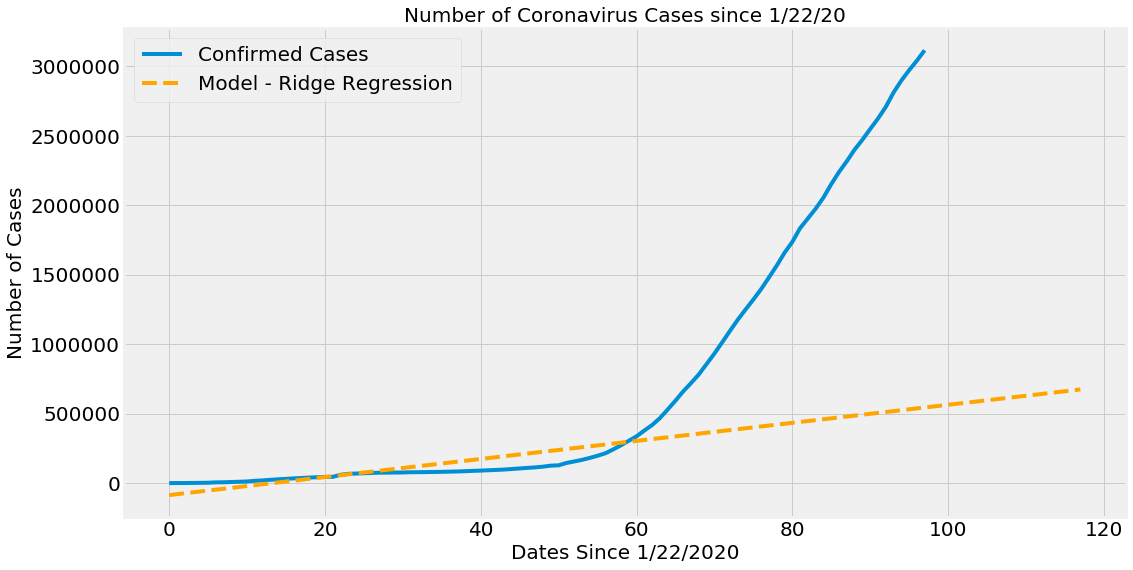

In [24]:
show_predict(dates_since_1_22, world_confirmed, ridge_pred, 'Model - Ridge Regression', 'orange')

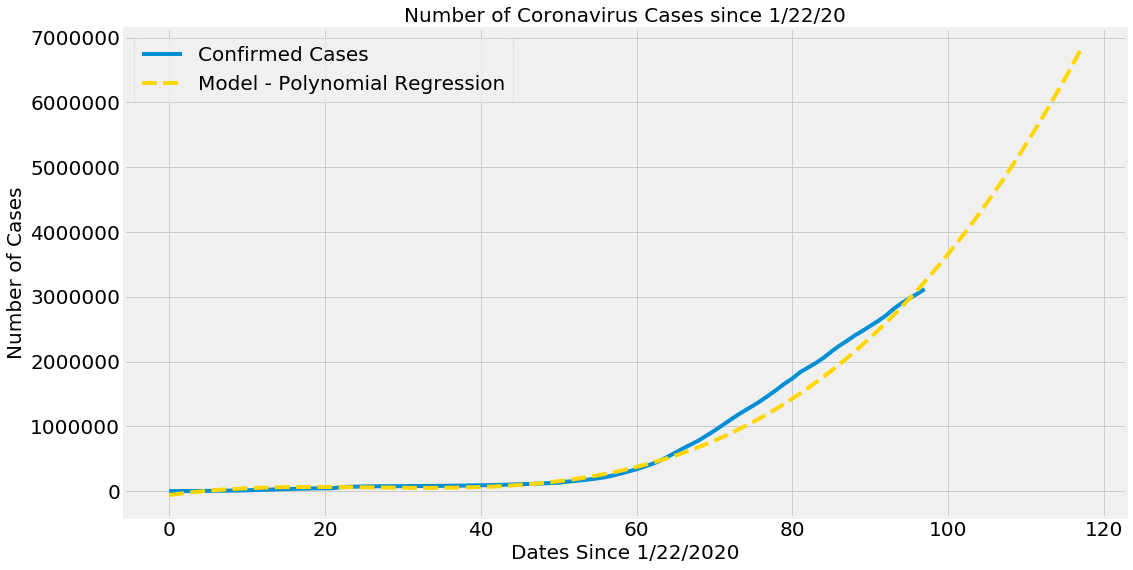

In [25]:
show_predict(dates_since_1_22, world_confirmed, poly_pred, 'Model - Polynomial Regression', 'gold')

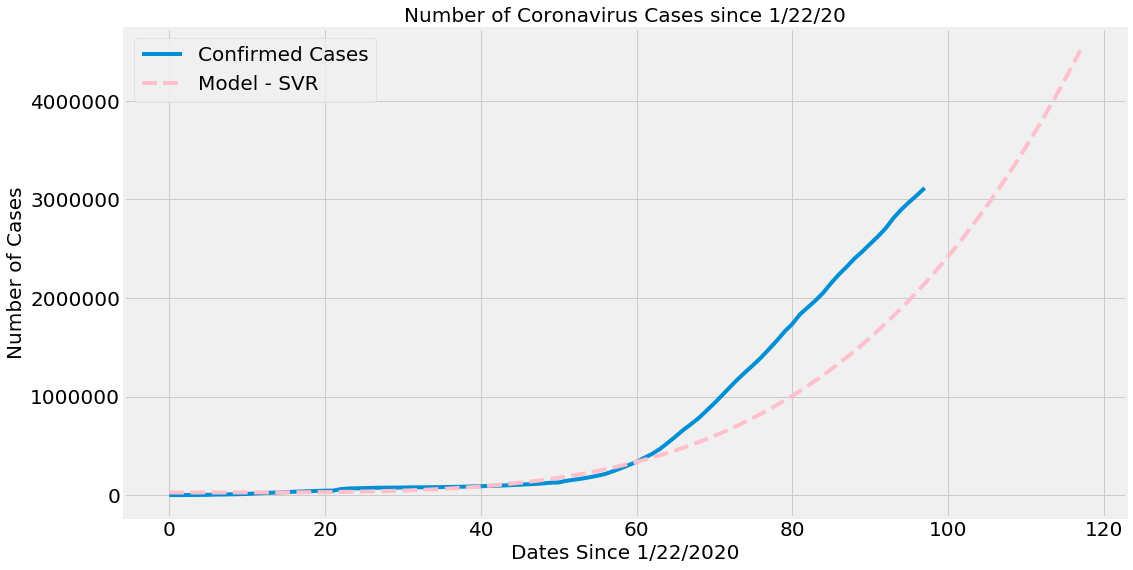

In [26]:
show_predict(dates_since_1_22, world_confirmed, svr_pred, 'Model - SVR', 'pink')

In [27]:
future_dates = np.array(['4/29/20', '4/30/20', '5/1/20', '5/2/20', '5/3/20', '5/4/20', '5/5/20', '5/6/20',
                '5/7/20', '5/8/20', '5/9/20', '5/10/20', '5/11/20', '5/12/20', '5/13/20', '5/14/20',
                '5/15/20', '5/16/20', '5/17/20', '5/18/20'])

In [28]:
# output each predictions for the future 20 days

svr_df = pd.DataFrame({'Date': future_dates[:], \
                       'SVR Predicted Number of Confirmed Cases': np.round(svr_pred[-20:])})
svr_df

,Date,SVR Predicted Number of Confirmed Cases
0,4/29/20,2235152.0
1,4/30/20,2326681.0
2,5/1/20,2421027.0
3,5/2/20,2518245.0
4,5/3/20,2618395.0
5,5/4/20,2721534.0
6,5/5/20,2827721.0
7,5/6/20,2937016.0
8,5/7/20,3049478.0
9,5/8/20,3165169.0


In [29]:
podf = poly_pred.reshape(118,)
poly_df = pd.DataFrame({'Date': future_dates[:], \
                        'Polynomial Reg Predicted Number of Confirmed Cases': np.round(podf[-20:])})
poly_df

,Date,Polynomial Reg Predicted Number of Confirmed Cases
0,4/29/20,3368579.0
1,4/30/20,3510842.0
2,5/1/20,3657081.0
3,5/2/20,3807352.0
4,5/3/20,3961707.0
5,5/4/20,4120202.0
6,5/5/20,4282891.0
7,5/6/20,4449827.0
8,5/7/20,4621067.0
9,5/8/20,4796662.0


In [30]:
rd = ridge_pred.reshape(118,)
ridge_df = pd.DataFrame({'Date': future_dates[:], 'Ridge Regression Predicted Number': np.round(rd[-20:])})
ridge_df

,Date,Ridge Regression Predicted Number
0,4/29/20,551021.0
1,4/30/20,557520.0
2,5/1/20,564019.0
3,5/2/20,570517.0
4,5/3/20,577016.0
5,5/4/20,583515.0
6,5/5/20,590014.0
7,5/6/20,596513.0
8,5/7/20,603011.0
9,5/8/20,609510.0


### Choose SVR as study model

In [31]:
# Let's look inside 3 countries : China, US and Canada

countrys = world_confirmed_df['Country/Region'].unique()
key = world_confirmed_df.keys()
date = key[4:]
A = {}
for i in countrys:
    for j in date:
        temp = world_confirmed_df[world_confirmed_df['Country/Region']==i][j].sum()
    A[i] = temp
from collections import Counter 
k = Counter(A) 
# Finding 10 highest values
high = k.most_common(10)
print("10 countries has the highest confirmed cases:") 
print("Country: Confirmed number") 
for i in high:
    print(i[0],":",i[1]," ")

10 countries has the highest confirmed cases:
Country: Confirmed number
US : 1012582  
Spain : 232128  
Italy : 201505  
France : 169053  
United Kingdom : 162350  
Germany : 159912  
Turkey : 114653  
Russia : 93558  
Iran : 92584  
China : 83940  


In [32]:
# -------------------------- confirmed cases --------------------------------------------------
US_confirme = [] 
Spain_confirme = [] 
Italy_confirme = []
France_confirme = [] 
UK_confirme = [] 
China_confirme = [] 
Canada_confirme = []

for i in date:
    US_confirme.append(world_confirmed_df[world_confirmed_df['Country/Region']=='US'][i].sum())
    Spain_confirme.append(world_confirmed_df[world_confirmed_df['Country/Region']=='Spain'][i].sum())
    Italy_confirme.append(world_confirmed_df[world_confirmed_df['Country/Region']=='Italy'][i].sum())
    France_confirme.append(world_confirmed_df[world_confirmed_df['Country/Region']=='France'][i].sum())
    UK_confirme.append(world_confirmed_df[world_confirmed_df['Country/Region']=='United Kingdom'][i].sum())
    China_confirme.append(world_confirmed_df[world_confirmed_df['Country/Region']=='China'][i].sum())
    Canada_confirme.append(world_confirmed_df[world_confirmed_df['Country/Region']=='Canada'][i].sum())
# -------------------------- confirmed cases --------------------------------------------------
# --------------------------  deaths  cases  --------------------------------------------------
US_death = [] 
Spain_death = [] 
Italy_death = []
France_death = [] 
UK_death = [] 
China_death = []
Canada_death = []

for i in date:
    US_death.append(world_deaths_df[world_deaths_df['Country/Region']=='US'][i].sum())
    Spain_death.append(world_deaths_df[world_deaths_df['Country/Region']=='Spain'][i].sum())
    Italy_death.append(world_deaths_df[world_deaths_df['Country/Region']=='Italy'][i].sum())
    France_death.append(world_deaths_df[world_deaths_df['Country/Region']=='France'][i].sum())
    UK_death.append(world_deaths_df[world_deaths_df['Country/Region']=='United Kingdom'][i].sum())
    China_death.append(world_deaths_df[world_deaths_df['Country/Region']=='China'][i].sum())
    Canada_death.append(world_deaths_df[world_deaths_df['Country/Region']=='Canada'][i].sum())
# --------------------------  deaths  cases  --------------------------------------------------
# -------------------------- recovered cases --------------------------------------------------
US_recovered = [] 
Spain_recovered = [] 
Italy_recovered = []
France_recovered = [] 
UK_recovered = [] 
China_recovered = []
Canada_recovered = []

for i in date:
    US_recovered.append(world_recovered_df[world_recovered_df['Country/Region']=='US'][i].sum())
    Spain_recovered.append(world_recovered_df[world_recovered_df['Country/Region']=='Spain'][i].sum())
    Italy_recovered.append(world_recovered_df[world_recovered_df['Country/Region']=='Italy'][i].sum())
    France_recovered.append(world_recovered_df[world_recovered_df['Country/Region']=='France'][i].sum())
    UK_recovered.append(world_recovered_df[world_recovered_df['Country/Region']=='United Kingdom'][i].sum())
    China_recovered.append(world_recovered_df[world_recovered_df['Country/Region']=='China'][i].sum())
    Canada_recovered.append(world_recovered_df[world_recovered_df['Country/Region']=='Canada'][i].sum())
# -------------------------- recovered cases --------------------------------------------------

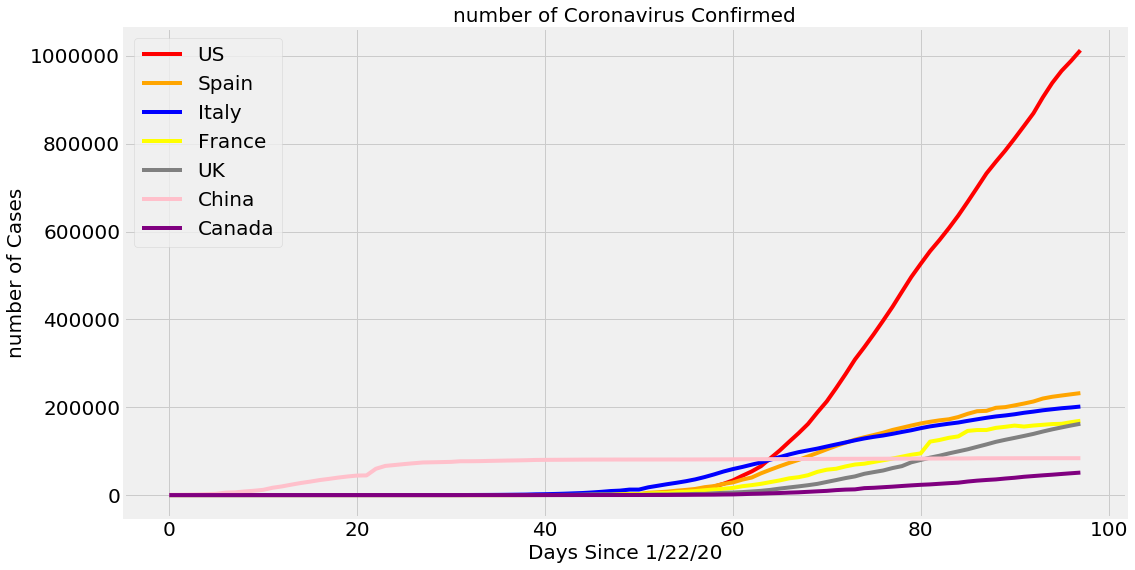

In [33]:
# -------- Start ploting specific countries line ---------------------
# Confirmed cases
plt.figure(figsize=(16, 9))
plt.plot(dates, US_confirme,color = "red")
plt.plot(dates, Spain_confirme,color = "orange")
plt.plot(dates, Italy_confirme,color = "blue")
plt.plot(dates, France_confirme,color = "yellow")
plt.plot(dates, UK_confirme,color = "gray")
plt.plot(dates, China_confirme,color = "pink")
plt.plot(dates, Canada_confirme,color = "purple")

plt.title('number of Coronavirus Confirmed', size=20)
plt.xlabel('Days Since 1/22/20', size=20)
plt.ylabel('number of Cases', size=20)
plt.legend(['US','Spain', 'Italy', 'France', 'UK','China','Canada'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

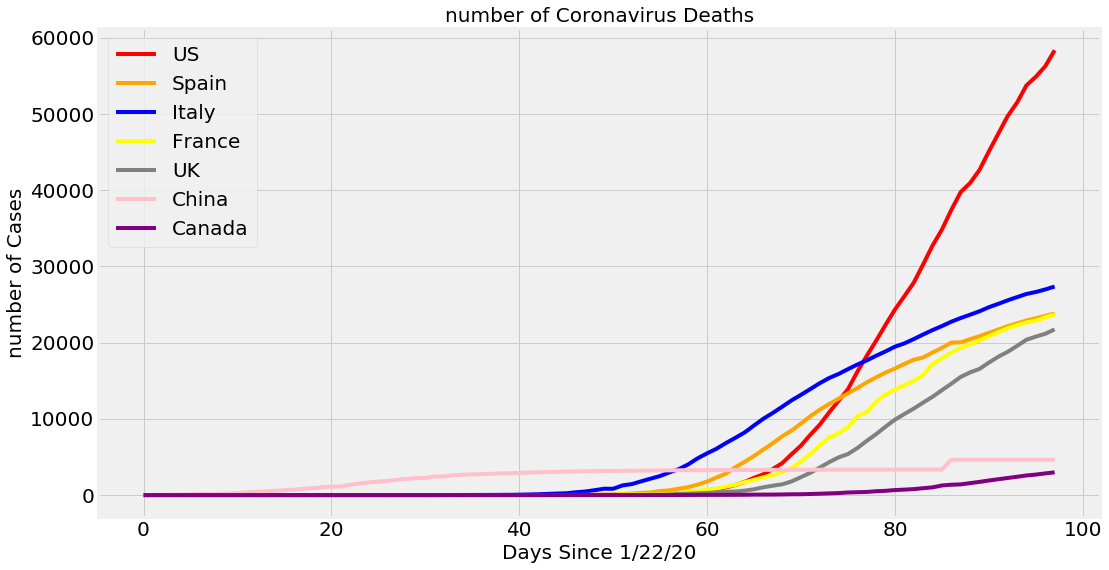

In [34]:
# Deaths cases
plt.figure(figsize=(16, 9))
plt.plot(dates, US_death,color = "red")
plt.plot(dates, Spain_death,color = "orange")
plt.plot(dates, Italy_death,color = "blue")
plt.plot(dates, France_death,color = "yellow")
plt.plot(dates, UK_death,color = "gray")
plt.plot(dates, China_death,color = "pink")
plt.plot(dates, Canada_death,color = "purple")

plt.title('number of Coronavirus Deaths', size=20)
plt.xlabel('Days Since 1/22/20', size=20)
plt.ylabel('number of Cases', size=20)
plt.legend(['US','Spain', 'Italy', 'France', 'UK','China','Canada'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

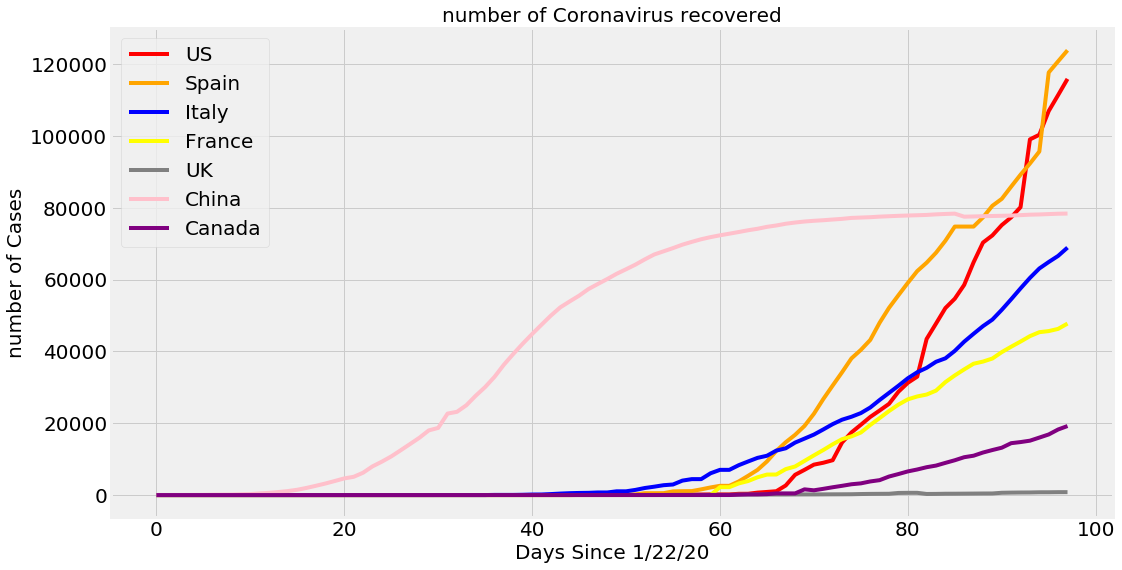

In [35]:
# recovered cases
plt.figure(figsize=(16, 9))
plt.plot(dates, US_recovered,color = "red")
plt.plot(dates, Spain_recovered,color = "orange")
plt.plot(dates, Italy_recovered,color = "blue")
plt.plot(dates, France_recovered,color = "yellow")
plt.plot(dates, UK_recovered,color = "gray")
plt.plot(dates, China_recovered,color = "pink")
plt.plot(dates, Canada_recovered,color = "purple")

plt.title('number of Coronavirus recovered', size=20)
plt.xlabel('Days Since 1/22/20', size=20)
plt.ylabel('number of Cases', size=20)
plt.legend(['US','Spain', 'Italy', 'France', 'UK','China','Canada'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [36]:
# Start training model - SVR
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(dates_since_1_22, \
                                                                US_confirme,test_size=.3, \
                                                                shuffle=False)
X_train_cn, X_test_cn, y_train_cn, y_test_cn = train_test_split(dates_since_1_22, \
                                                                China_confirme,test_size=.3, \
                                                                shuffle=False)
X_train_ca, X_test_ca, y_train_ca, y_test_ca = train_test_split(dates_since_1_22, \
                                                                Canada_confirme,test_size=.3, \
                                                                shuffle=False)

In [37]:
svr_us = SVR(shrinking=True, kernel='poly', gamma=.01, epsilon=.1, degree=4, C=.1)
svr_us.fit(X_train_us, y_train_us)
svr_us_pred = svr_us.predict(pred_future)

svr_cn = SVR(shrinking=True, kernel='poly', gamma=.01, epsilon=.1, degree=4, C=.1)
svr_cn.fit(X_train_cn, y_train_cn)
svr_cn_pred = svr_cn.predict(pred_future)
ridge_cn = Ridge(alpha=.1)
ridge.fit(X_train_cn, y_train_cn)
ridge_cn_pred = ridge.predict(pred_future)

svr_ca = SVR(shrinking=True, kernel='poly', gamma=.01, epsilon=.1, degree=4, C=.1)
svr_ca.fit(X_train_ca, y_train_ca)
svr_ca_pred = svr_us.predict(pred_future)

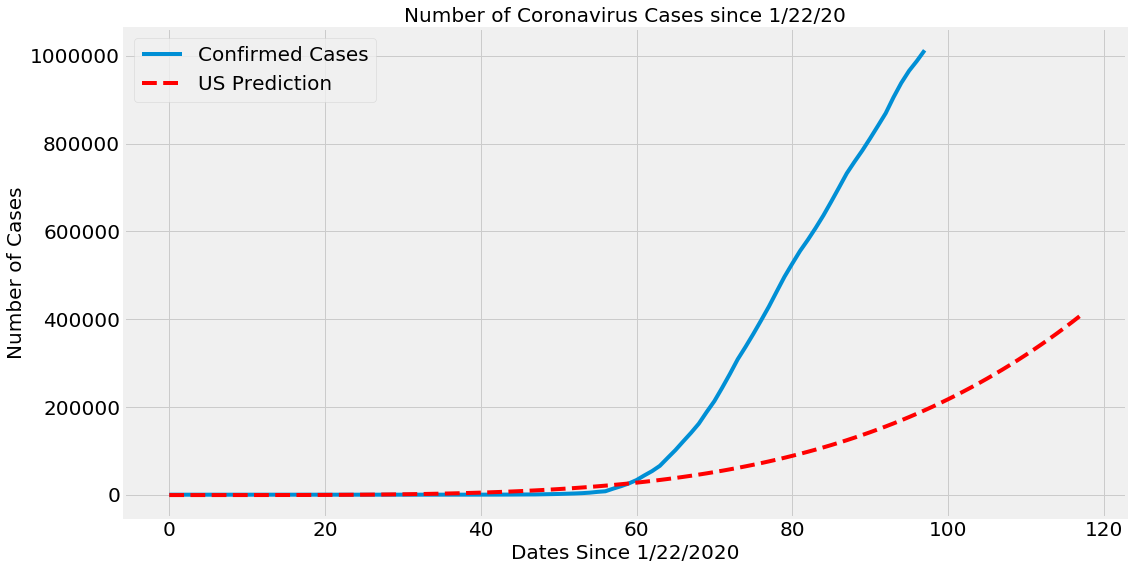

In [38]:
show_predict(dates_since_1_22, US_confirme, svr_us_pred, 'US Prediction', 'red')

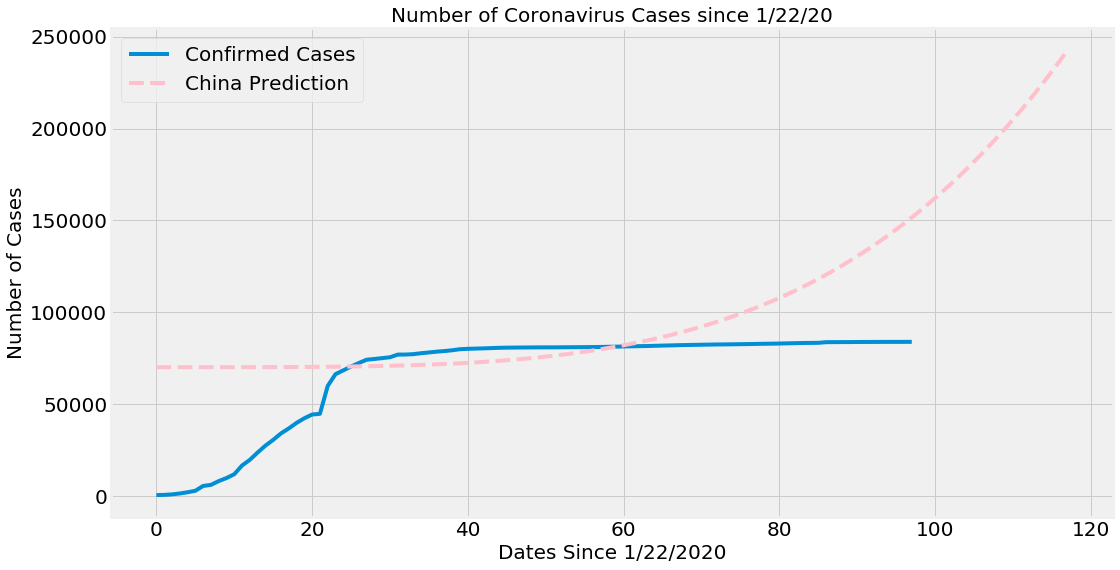

In [39]:
show_predict(dates_since_1_22, China_confirme, svr_cn_pred, 'China Prediction', 'pink')

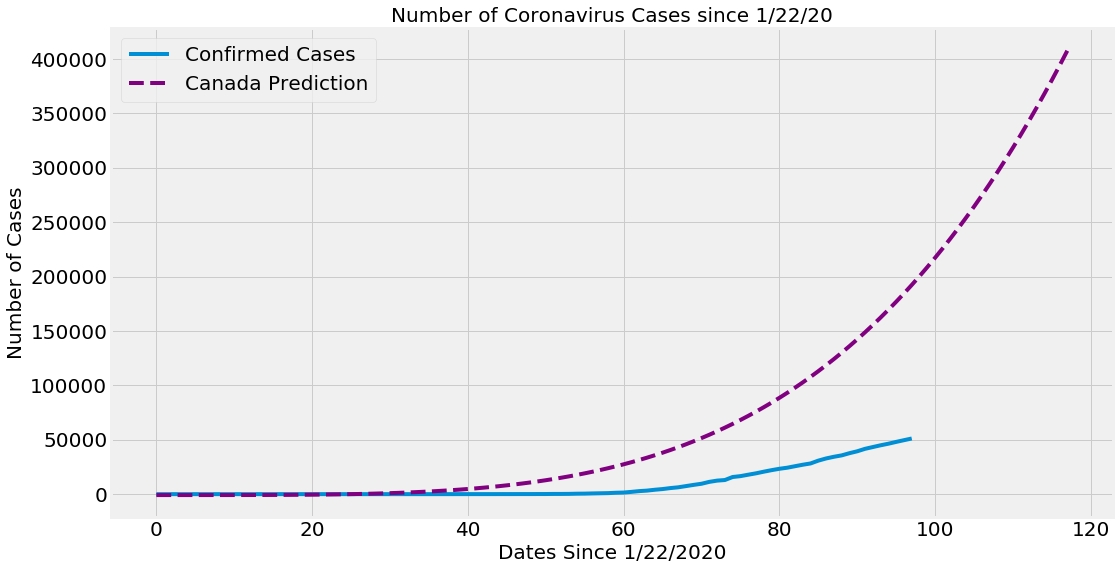

In [40]:
show_predict(dates_since_1_22, Canada_confirme, svr_ca_pred, 'Canada Prediction', 'purple')

## Summary
- This is the end of our project, and if you can find more information and explanation in our git:
- https://github.com/Ding3LI/covid-19_pred
- As well as our project's presentation, we have detaily explained our project as well.
- Finally, our project for predicting for specific countries seems failed, because the error is too large to be considered. And as you can see the prediction curve for China, the prediction seems not making any sense for prediction. Hence, our project's previous of predicting world-wide seems success. Moreover, stay healthy and stay calm.